# Song Stream Predictions

### Connecting to Snowflake

This script sets up a connection to Snowflake using SQLAlchemy, facilitates query execution through context management, and provides specific functions (get_sodatone_query_dfs and get_sodatone_query_df) tailored for interacting with Snowflake in a Sodatone-specific context. Sodatone is a specialized data analytics platform tailored for the music industry. It provides comprehensive insights into streaming data from major platforms like Spotify and Apple Music. With Sodatone, we can track performance metrics, analyze audience demographics, and leverage predictive analytics to drive date-driven signings

In [1]:
# imports
import sys
import pandas as pd
from io import BytesIO
import numpy as np
sys.path.append('..')
import snowflake
import contextlib
from sqlalchemy import create_engine
from typing import List
from IPython.display import display
# import okta1

import os
from dotenv import load_dotenv
load_dotenv()



# import dodb
pd.options.display.max_columns = None

# WMG Snowflake general
SNOWFLAKE_AUTHENTICATOR="https://wmg.okta.com"
SNOWFLAKE_ACCOUNT="wmg-datalab"

# Sodatone-specific
SNOWFLAKE_SODATONE_ROLE="ENT_OKTA_SNOWFLAKE_DATALAB_ATLANTIC"
SNOWFLAKE_SODATONE_WAREHOUSE="ATLANTIC_SANDBOX_WH_XS"



# --- CONFIG ---
# your okta email
SNOWFLAKE_OKTA_USER = os.getenv("OKTA_EMAIL")
# your okta password
SNOWFLAKE_OKTA_PASSWORD = os.getenv("OKTA_PASSWORD")
def _get_engine(
        role: str,
        warehouse: str,
        user: str = SNOWFLAKE_OKTA_USER,
        password: str = SNOWFLAKE_OKTA_PASSWORD,
        account: str = SNOWFLAKE_ACCOUNT,
        authenticator: str = SNOWFLAKE_AUTHENTICATOR):
    return create_engine(
        _get_engine_url(role, warehouse, user, password, account),
        connect_args={
            # this will open your computer's default web-browser so you can auth with okta
            # then it will redirect to localhost with a token... that token is consumed by
            # the snowflake engine in order to authenticate queries
            # however, the engine needs to be recreated because of context decorator, so
            # sql queries should be grouped into an iterable of multiple statements to
            # prevent annoying window popups
            'authenticator': 'externalbrowser',
        },
    )

def _get_engine_url(role: str, warehouse: str, user: str, password: str, account: str) -> str:
    return (
        'snowflake://{user}:{password}@{account}/?warehouse={warehouse}&role={role}'.format(
            user=user,
            password=password,
            account=account,
            warehouse=warehouse,
            role=role,
        )
    )

@contextlib.contextmanager
def _get_conn(engine):
    conn = engine.connect()
    try:
        yield conn
    finally:
        conn.close()
        engine.dispose()

def _get_role_conn(role: str, warehouse: str):
    return _get_conn(_get_engine(role, warehouse))

def get_results_as_dfs(role: str, warehouse: str, sql_queries: List[str]) -> List[pd.DataFrame]:
    with _get_role_conn(role, warehouse) as conn:
        print(f"Running sql as {role} in warehouse: {warehouse}")
        return [pd.read_sql(x, conn) for x in sql_queries]

def get_sodatone_query_dfs(sql: List[str]):
    # sodatone specific
    return get_results_as_dfs(SNOWFLAKE_SODATONE_ROLE, SNOWFLAKE_SODATONE_WAREHOUSE, sql)
def get_results_as_df(role: str, warehouse: str, sql_query: str) -> pd.DataFrame:
    with _get_role_conn(role, warehouse) as conn:
        print(f"Running sql as {role} in warehouse: {warehouse}")
        return pd.read_sql(sql_query, conn)
    
def get_sodatone_query_df(sql: str):
    # sodatone specific
    return get_results_as_df(SNOWFLAKE_SODATONE_ROLE, SNOWFLAKE_SODATONE_WAREHOUSE, sql)

In [2]:
query = '''WITH joined AS (
  SELECT
    m.ARTIST,
    m.TITLE,
    m.UNIFIED_SONG_ID,
    m.DATE,
    t.RELEASE_DATE,
    m.THIS_DAY,
    m.THIS_WEEK,
    m.DATE - CAST(t.RELEASE_DATE AS DATE) AS DAYS_SINCE_RELEASE,
    (DAYOFWEEK(m.DATE) + 2) % 7 AS day_of_week,
    ROW_NUMBER() OVER(PARTITION BY m.UNIFIED_SONG_ID, m.DATE, t.RELEASE_DATE ORDER BY (SELECT NULL)) AS rn,
    END_OF_WEEK,
    POPULARITY
  FROM
    "SODATONE"."SODATONE"."LUMINATE_DAILY_SONG_METRICS" AS m
  JOIN
    "APP_REACT"."JOHN_S"."FINAL_TRACKS" AS t ON m.UNIFIED_SONG_ID = t.UNIFIED_SONG_ID
  WHERE
    m.METRIC_TYPE = 'Streaming On-Demand Audio'
    AND m.REGION = 'us'
    AND DAYS_SINCE_RELEASE >= 0
    AND DATE > '2024-01-01'
),
EarliestReleases AS (
    SELECT
        UNIFIED_SONG_ID,
        MIN(RELEASE_DATE) AS earliest_release_date
    FROM
        joined
    GROUP BY
        UNIFIED_SONG_ID
),
filtered_joined AS (
    SELECT
        j.*
    FROM
        joined AS j
    JOIN
        EarliestReleases e
    ON
        j.UNIFIED_SONG_ID = e.UNIFIED_SONG_ID
        AND j.RELEASE_DATE = e.earliest_release_date
    WHERE
        rn = 1
),
lag AS (
  SELECT *,
     THIS_DAY AS day_0,
     LAG(THIS_DAY, 1, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_1,
     LAG(THIS_DAY, 2, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_2,
     LAG(THIS_DAY, 3, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_3,
     LAG(THIS_DAY, 4, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_4,
     LAG(THIS_DAY, 5, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_5,
     LAG(THIS_DAY, 6, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS day_6,
     LEAD(THIS_WEEK, 8, NULL) OVER(PARTITION BY UNIFIED_SONG_ID ORDER BY DATE ASC) AS target
  FROM filtered_joined
)
SELECT 
    * 
FROM 
    lag
WHERE 
    target IS NOT NULL
    AND END_OF_WEEK = TRUE
ORDER BY 
    UNIFIED_SONG_ID, DATE DESC;'''

In [3]:
df = get_sodatone_query_df(query)
df

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://wmg.okta.com/app/snowflake/exkab0aaa1IEBMlNX2p7/sso/saml?SAMLRequest=jZJBc9owEIX%2Fikc927IdA7EGyDhAWjfB0EA6mdyELUCDLDlaOSb%2FvrIJHXpIpjeN9N7ut3o7vDmWwnljGriSIxR4PnKYzFXB5W6EntZ37jVywFBZUKEkG6F3BuhmPARaiooktdnLR%2FZaMzCOLSSBdA8jVGtJFAUORNKSATE5WSXzBxJ6Pqm0MipXAl1YvnZQAKaNJTxbCuAWb29MRTBumsZrrjyldzj0fR%2F7MbaqVvLtrD%2FamT7RB9iPWr1VWPnyg%2B2Wy9MXfIW1OYmA%2FFivl%2B5ysVojJzmjTpSEumR6xfQbz9nT48MJAFqCcucW1FBBNx5I1WwFPbBclVVtbD3PnvCWFVioHbcjp9MRqg68iAf3TfGLzr%2F3fr5k2STIkt5ilkyuZ%2F34efJax1kVLpN9vEg3UY6c3%2BdMwzbTFKBmqWyTNPbKDyPX77vhYB2GJIpIz%2Ff6V9ELcqY2SS6p6ZwXuJ46GNqB0arCf5kxOx7oxqeUBunsdi6y57AaYACF21DRaU9I11yP%2F3%2F6Ib70fSxbZv8%2FnS6V4Pm7c6d0Sc3n8QRe0N3wwt12UsJKykVSFJoB2JiEUM1EM2rsThtdM4THp67%2FbvX4Dw%3D%3D&RelayState=54939 to authentic

,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,rn,end_of_week,popularity,day_0,day_1,day_2,day_3,day_4,day_5,day_6,target
0,Young Thug,Hercules,100070,2024-06-13,2016-02-05,15999,101589.0,3051,6,1,True,48,15999,15412.0,15053.0,13938.0,12305.0,14530.0,16076.0,100850
1,Young Thug,Hercules,100070,2024-06-06,2016-02-05,15357,100364.0,3044,6,1,True,48,15357,15191.0,14927.0,14039.0,12311.0,14205.0,15559.0,103313
2,Young Thug,Hercules,100070,2024-05-30,2016-02-05,15457,103225.0,3037,6,1,True,48,15457,15049.0,14144.0,12212.0,12667.0,14507.0,16328.0,101589
3,Young Thug,Hercules,100070,2024-05-23,2016-02-05,15598,103165.0,3030,6,1,True,48,15598,15460.0,15692.0,14715.0,12363.0,13894.0,15503.0,100364
4,Young Thug,Hercules,100070,2024-05-16,2016-02-05,15682,103814.0,3023,6,1,True,48,15682,15269.0,14937.0,14127.0,12459.0,14773.0,15918.0,102812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195607,Don Toliver,New Drop,243502812,2024-06-13,2024-06-13,702,NaN,0,6,1,True,0,702,NaN,NaN,NaN,NaN,NaN,NaN,3726859
195608,Don Toliver,5 To 10,243502816,2024-06-13,2024-06-13,600,NaN,0,6,1,True,0,600,NaN,NaN,NaN,NaN,NaN,NaN,2756571
195609,Don Toliver,Last Laugh,243502819,2024-06-13,2024-06-13,552,NaN,0,6,1,True,0,552,NaN,NaN,NaN,NaN,NaN,NaN,2231508
195610,Don Toliver,Hardstone National Anthem,243502822,2024-06-13,2024-06-13,522,NaN,0,6,1,True,0,522,NaN,NaN,NaN,NaN,NaN,NaN,1757961


In [4]:
df.to_csv('csv_files/snowflake_data.csv', index=False)

# Load the DataFrame from the CSV file
data = pd.read_csv('csv_files/snowflake_data.csv')

In [5]:
days = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']

data['sum'] = sum([data[day] for day in days])
data.head(100)

,artist,title,unified_song_id,date,release_date,this_day,this_week,days_since_release,day_of_week,rn,end_of_week,popularity,day_0,day_1,day_2,day_3,day_4,day_5,day_6,target,sum
0,Young Thug,Hercules,100070,2024-06-13,2016-02-05,15999,101589.0,3051,6,1,True,48,15999,15412.0,15053.0,13938.0,12305.0,14530.0,16076.0,100850,103313.0
1,Young Thug,Hercules,100070,2024-06-06,2016-02-05,15357,100364.0,3044,6,1,True,48,15357,15191.0,14927.0,14039.0,12311.0,14205.0,15559.0,103313,101589.0
2,Young Thug,Hercules,100070,2024-05-30,2016-02-05,15457,103225.0,3037,6,1,True,48,15457,15049.0,14144.0,12212.0,12667.0,14507.0,16328.0,101589,100364.0
3,Young Thug,Hercules,100070,2024-05-23,2016-02-05,15598,103165.0,3030,6,1,True,48,15598,15460.0,15692.0,14715.0,12363.0,13894.0,15503.0,100364,103225.0
4,Young Thug,Hercules,100070,2024-05-16,2016-02-05,15682,103814.0,3023,6,1,True,48,15682,15269.0,14937.0,14127.0,12459.0,14773.0,15918.0,102812,103165.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Skillet,Undefeated,259308,2024-06-13,2016-08-05,13028,80333.0,2869,6,1,True,53,13028,12739.0,12801.0,12150.0,9448.0,10667.0,12613.0,85427,83446.0
96,Skillet,Undefeated,259308,2024-06-06,2016-08-05,12295,71391.0,2862,6,1,True,53,12295,12374.0,12112.0,12165.0,9496.0,10743.0,11148.0,83446,80333.0
97,Skillet,Undefeated,259308,2024-05-30,2016-08-05,11356,78318.0,2855,6,1,True,53,11356,11312.0,10615.0,8722.0,8319.0,9793.0,11274.0,80332,71391.0
98,Skillet,Undefeated,259308,2024-05-23,2016-08-05,11895,78976.0,2848,6,1,True,53,11895,11742.0,12055.0,11567.0,8985.0,10369.0,11705.0,71391,78318.0


In [6]:
ex2 = df[['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'target']]
ex2 = ex2.dropna()

x, y = ex2.drop('target', axis=1), ex2['target']


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100)
m = LinearRegression()
m.fit(x_train, y_train)
f"{mean_squared_error(m.predict(x_train), y_train):0.3e}"

NameError: name 'train_test_split' is not defined

### Data Cleansing/EDA

First, let's check if we have any duplicates (we shouldn't since the query should handle that). 

In the output below, we can see that there is some weird stuff going on with the 0 values. The number of streams jumps from a very high value to a very low value, and then to 0. For example, row 386 jumps from 51743 streams on day_3, to 5 streams on day_4, to 0 streams on day_5. Thus, we can essentially treat the zeros as null values. This will allow us to perform interpolation on these null values later on.

In [ ]:
pd.set_option('display.max_rows', 200)

days = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']
features = ['day_of_week', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'target']

duplicates = df[df.duplicated(['unified_song_id'], keep=False)]
print("Number of duplicates: ", len(duplicates))

dropped = df.drop(columns=['this_week'], axis=1)

# Shows all rows where there is a 0 in any of the columns in 'days'
dropped[(dropped[days] == 0).any(axis=1)][features].head(10)

In [ ]:
new_df = dropped.copy()[features]
new_df[days] = new_df[days].replace(0, np.nan)

print("Number of rows with null values: ", (len(new_df) - len(new_df.dropna())))
print("Number of rows will null values in all day_n columns: ", new_df[new_df[days].isnull().all(axis=1)].shape[0])

new_df.loc[[3254], :]

If we look at item 3254 from the original table, we can see that day_0 through day_4 have non null values, with day_5 and day_6 having null values. Here, we use a method called interpolating to fill NaN values with an estimated value based on existing values in the row.


In [ ]:
# First we drop all the rows where there is a null value in each day_N column
filt = new_df[days].isnull().all(axis=1)
temp = new_df[~filt]

# Now we interpolate all of the remaining null values
filled = temp.copy()
filled[days] = filled[days].interpolate(method='linear', axis=1)

filled[filled.isnull().any(axis=1)]

In [ ]:
# We can backwards fill row 6743, but we will drop the remaining rows with null values 
# because they do not appear to be significant

filled[days] = filled[days].bfill(axis=1)
# filled = filled.dropna()

# Finally, let's see how the null values in row 3254 changed
filled

In [ ]:
final = filled.copy()

# Add percent change columns to our final table as an extra feature
final.loc[:, '1_day_%_change'] = ((final['day_0'] - final['day_1']) / final['day_1']) * 100
final.loc[:, '3_day_%_change'] = ((final['day_0'] - final['day_3']) / final['day_3']) * 100
final.loc[:, '6_day_%_change'] = ((final['day_0'] - final['day_6']) / final['day_6']) * 100

# Rearrange the 'target' column so it is the last column in the DataFrame
final = final[[c for c in final if c != 'target'] + ['target']]
final

In [ ]:


]?\

In [ ]:
# def plot_distribution(data, label):
#     fig, axs = plt.subplots(nrows=2)

#     sns.displot(
#         data = data, 
#         x = label
#         kind = 'hist'
#     )
#     sns.boxplot(
#         x=data[label],
#         width=0.3, 
#         ax=axs[1],
#         showfliers=False,
#     )

#     # Align axes
#     spacer = np.max(data[label]) * 0.05
#     xmin = np.min(data[label]) - spacer
#     xmax = np.max(data[label]) + spacer
#     axs[0].set_xlim((xmin, xmax))
#     axs[1].set_xlim((xmin, xmax))

#     # Remove some axis text
#     axs[0].xaxis.set_visible(False)
#     axs[0].yaxis.set_visible(False)
#     axs[1].yaxis.set_visible(False)

#     # Put the two plots together
#     plt.subplots_adjust(hspace=0)

sns.boxplot(data=filled, x='day_0')

# For tomorrow: do feature engineering, apply transformations, etc.

In [38]:
X = final.drop('target', axis=1)
y = final['target']

# Split data into training and testing sets (test_size=0.1 for 10% test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

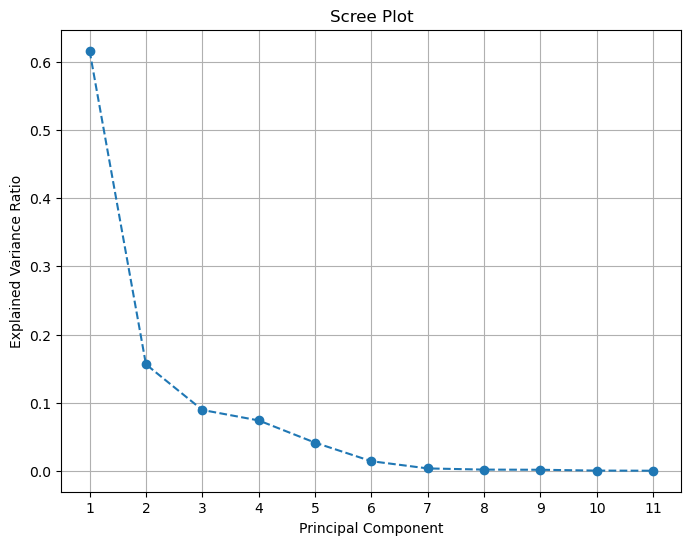

In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA()
pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

In [42]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()

# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

pipe = Pipeline([
    ("scaler", scaler), 
     ("pca", pca), 
     ("regressor", Ridge())
])

# Parameters of pipelines can be set using '__' separated parameter names:
params = {
    "regressor": [Ridge(), Lasso()],
    "pca__n_components": [1, 2, 3, 4, 5, 10],
    "regressor__alpha": [0.1, 1.0, 10, 20]
}
     
search = GridSearchCV(pipe, params, cv=5, scoring='neg_mean_squared_error')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3e):" % search.best_score_)
print(search.best_params_)

best_model = search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate test MSE
test_mse = mean_squared_error(y_test, y_pred)
print(f"Model Test MSE: {test_mse:0.3e}")

baseline_train = np.full_like(y_train, np.mean(y_train))
baseline_test = np.full_like(y_test, np.mean(y_train))

baseline_train_mse = mean_squared_error(baseline_train, y_train)
baseline_test_mse = mean_squared_error(baseline_test, y_test)

print(f"Baseline Model Train MSE: {baseline_train_mse:0.3e}")
print(f"Baseline Model Test MSE: {baseline_test_mse:0.3e}")

Best parameter (CV score=-1.270e+11):
{'pca__n_components': 10, 'regressor': Ridge(alpha=10), 'regressor__alpha': 10}
Model Test MSE: 1.436e+11
Baseline Model Train MSE: 4.341e+12
Baseline Model Test MSE: 3.730e+12


In [43]:
X1 = final.drop('target', axis=1)  # Replace with your target column name
y1 = final['target']

# Split data into training and testing sets (test_size=0.1 for 10% test data)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=42)

# Create the linear regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X1_train, y1_train)

# Use the trained model to make predictions on the test data
y_train_pred = model.predict(X1_train)
y_test_pred = model.predict(X1_test)

train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_test_pred, y_test)

print(f"Model Train MSE: {train_mse:0.3e}")
print(f"Model Test MSE: {test_mse:0.3e}")

print(f"Baseline Model Test MSE: {baseline_test_mse:0.3e}")

Model Train MSE: 1.141e+11
Model Test MSE: 1.432e+11
Baseline Model Test MSE: 3.730e+12


<AxesSubplot:ylabel='target'>

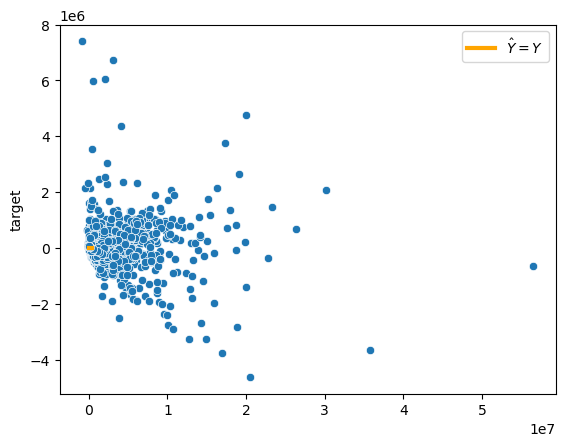

In [35]:
sns.scatterplot(x = y_train_pred, y = y_train - y_train_pred)
sns.lineplot(x=[-1, 400000], y=[0,0], label="$\hat{Y}=Y$", color = 'orange', linewidth = 3)